In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import pickle
from sklearn.model_selection import  train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

In [4]:
if os.path.split(os.getcwd())[-1] == 'notebooks': os.chdir(os.path.split(os.getcwd())[-2])
print(os.getcwd())

/home/fitzaudoen/apps/gas-sensor-analytics-demo


In [5]:
sns.set()
sns.set_context('talk')

# Run through the workflow without filtering any outliers

In [9]:
# Load raw data
input_fn = 'merged_data'
df = pd.read_pickle('data/interim/{}.pkl'.format(input_fn))
# Test, train, cross validation split
test_size = .4
train, testing = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
cross_validation, test = train_test_split(testing, test_size=0.5, random_state=42, shuffle=True)


In [17]:
# Array data
data = train.values
y_reg = data[:,2]
y = data[:,1]
X = data[:,3:]
X_cat = data[:,1:2]
# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Encode cateogrical
encoder = OneHotEncoder(sparse=False)
X_cat = encoder.fit_transform(X_cat)
X_reg = np.concatenate((X,X_cat),axis=1)
# Cross validation scale and encode
data_cv = cross_validation.values
y_cv = data_cv[:,1]
y_reg_cv = data_cv[:,2]
X_cv = data_cv[:,3:]
X_cat_cv = data_cv[:,1:2]
X_cv = scaler.transform(X_cv)
X_cat_cv = encoder.transform(X_cat_cv)
X_reg_cv = np.concatenate((X_cv,X_cat_cv),axis=1)

In [21]:
# Classification train
clf = SVC(C=400, max_iter=5000)
clf.fit(X,y)

SVC(C=400, max_iter=5000)

In [22]:
print('train class:',clf.score(X,y))
print('cross validate class:',clf.score(X_cv,y_cv))

train class: 0.9995207284926911
cross validate class: 0.9960460100647016


In [180]:
# Regression train
reg_svr = SVR(C=5000)
reg_svr.fit(X_reg,y_reg)

SVR(C=5000)

In [181]:
print('train class:',reg_svr.score(X_reg,y_reg))
print('cross validate class:',reg_svr.score(X_reg_cv,y_reg_cv))

train class: 0.9827382605873636
cross validate class: 0.9791442088103787


In [182]:
y_reg_pred = reg_svr.predict(X_reg)
error = abs(y_reg - y_reg_pred)/y_reg

y_reg_pred_cv = reg_svr.predict(X_reg_cv)
error_cv = abs(y_reg_cv - y_reg_pred_cv)/y_reg_cv

(0.0, 1.0)

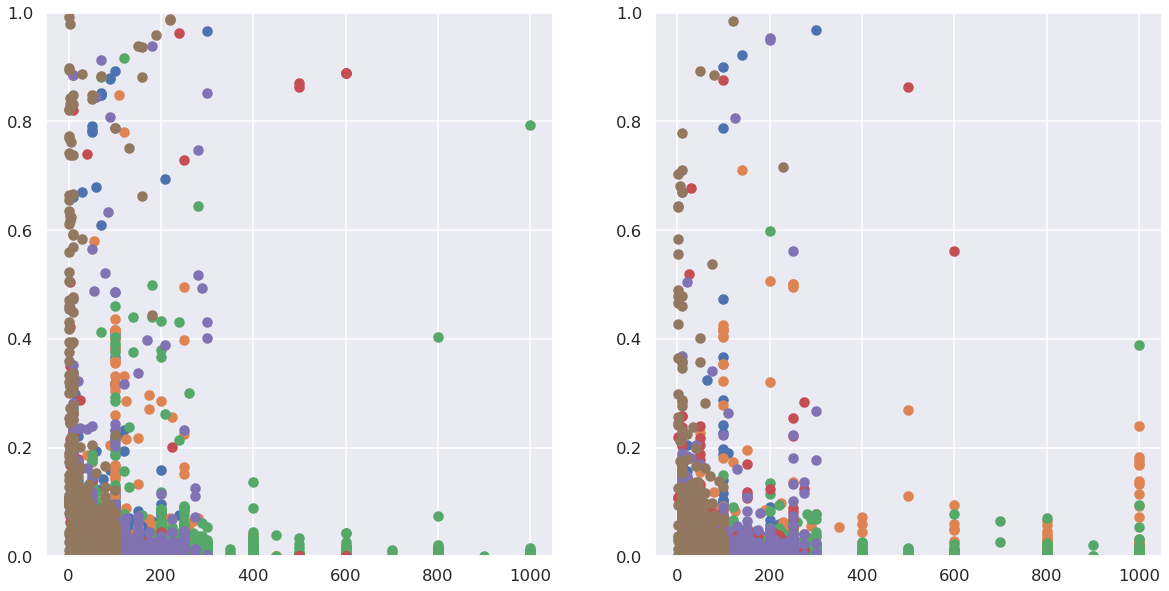

In [183]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
for gas in np.unique(y):
    ax[0].scatter(y_reg[y==gas], error[y==gas])
    ax[1].scatter(y_reg_cv[y_cv==gas], error_cv[y_cv==gas])
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

In [36]:
outliers = error>.2
outliers_cv = error_cv>.2
print('Ratio train error within 20%:',len(error[error>.2])/len(error))
print('Ratio cv error within 20%:',len(error_cv[error_cv>.2])/len(error_cv))

Ratio train error within 20%: 0.03906062784567457
Ratio cv error within 20%: 0.04816678648454349


## Looks like algorithm can handle perfectly fine not having extreme values removed initially

# Train Outlier Detection

In [142]:
clf_otlr = SVC(C=10000, max_iter=5000)

In [143]:
X_reg.shape
outliers.shape

(8346,)

In [144]:
clf_otlr.fit(X_reg,outliers)

/home/fitzaudoen/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=10000, max_iter=5000)

In [145]:
clf_otlr.score(X_reg, outliers)

0.8699976036424635

In [146]:
metrics.precision_recall_fscore_support(outliers,clf_otlr.predict(X_reg))

(array([0.98367973, 0.17757009]),
 array([0.87930175, 0.64110429]),
 array([0.92856673, 0.27811045]),
 array([8020,  326]))

In [147]:
metrics.precision_recall_fscore_support(outliers_cv,clf_otlr.predict(X_reg_cv))

(array([0.96918531, 0.14769976]),
 array([0.86706949, 0.45522388]),
 array([0.91528802, 0.22303473]),
 array([2648,  134]))

Not performing very well, only about 50% of outliers are being detected (poor recall)

In [160]:
clf_otlr2 = RandomForestClassifier(n_estimators=50, max_features='log2')
clf_otlr2.fit(X_reg,outliers)
clf_otlr2.score(X_reg, outliers)

0.9998801821231728

In [161]:
metrics.precision_recall_fscore_support(outliers,clf_otlr2.predict(X_reg))

(array([0.99987533, 1.        ]),
 array([1.        , 0.99693252]),
 array([0.99993766, 0.9984639 ]),
 array([8020,  326]))

In [162]:
metrics.precision_recall_fscore_support(outliers_cv,clf_otlr2.predict(X_reg_cv))

(array([0.96347699, 0.77272727]),
 array([0.99622356, 0.25373134]),
 array([0.97957668, 0.38202247]),
 array([2648,  134]))

# Try to see if regression improves with individual gases

(array([1752.,    0., 1171.,    0., 1069.,    0., 1805.,    0., 1544.,
        1005.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

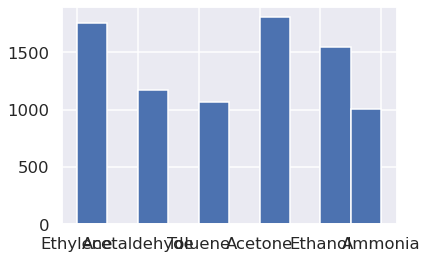

In [163]:
plt.hist(y)

(array([197.,  65.,  18.,  15.,  15.,   9.,   0.,   0.,   0.,   2.,   0.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([1.0, 50.95, 100.9, 150.85000000000002, 200.8, 250.75,
        300.70000000000005, 350.65000000000003, 400.6, 450.55, 500.5,
        550.45, 600.4000000000001, 650.35, 700.3000000000001, 750.25,
        800.2, 850.1500000000001, 900.1, 950.0500000000001, 1000.0],
       dtype=object),
 <BarContainer object of 20 artists>)

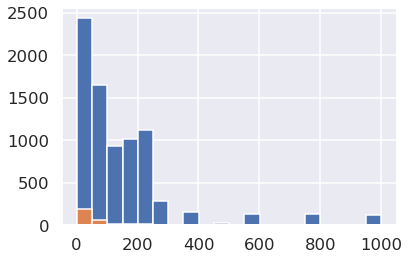

In [169]:
plt.hist(y_reg[~outliers],bins=20)
plt.hist(y_reg[outliers],bins=20)

Acetaldehyde
Ratio train error within 50%: 0.016225448334756618
Ratio cv error within 50%: 0.013404825737265416
F1 outliers train: (array([0.9965368, 0.9375   ]), array([0.99913194, 0.78947368]), array([0.99783268, 0.85714286]), array([1152,   19]))
F1 outliers cv: (array([0.98898072, 0.1       ]), array([0.97554348, 0.2       ]), array([0.98221614, 0.13333333]), array([368,   5]))
Acetone
Ratio train error within 50%: 0.020498614958448753
Ratio cv error within 50%: 0.022530329289428077
F1 outliers train: (array([0.99943407, 0.94736842]), array([0.99886878, 0.97297297]), array([0.99915134, 0.96      ]), array([1768,   37]))
F1 outliers cv: (array([0.9928952 , 0.64285714]), array([0.99113475, 0.69230769]), array([0.9920142 , 0.66666667]), array([564,  13]))
Ammonia
Ratio train error within 50%: 0.030845771144278607
Ratio cv error within 50%: 0.027439024390243903
F1 outliers train: (array([0.99084435, 1.        ]), array([1.        , 0.70967742]), array([0.99540112, 0.83018868]), array([

/home/fitzaudoen/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Ethanol
Ratio train error within 50%: 0.012953367875647668
Ratio cv error within 50%: 0.01904761904761905
F1 outliers train: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([1524,   20]))
F1 outliers cv: (array([0.99418605, 0.77777778]), array([0.9961165, 0.7      ]), array([0.99515034, 0.73684211]), array([515,  10]))
Ethylene
Ratio train error within 50%: 0.01141552511415525
Ratio cv error within 50%: 0.013582342954159592
F1 outliers train: (array([0.9954023, 1.       ]), array([1. , 0.6]), array([0.99769585, 0.75      ]), array([1732,   20]))
F1 outliers cv: (array([0.98793103, 0.11111111]), array([0.98623064, 0.125     ]), array([0.9870801 , 0.11764706]), array([581,   8]))


/home/fitzaudoen/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Toluene
Ratio train error within 50%: 0.019644527595884004
Ratio cv error within 50%: 0.035897435897435895
F1 outliers train: (array([0.99809524, 1.        ]), array([1.       , 0.9047619]), array([0.99904671, 0.95      ]), array([1048,   21]))
F1 outliers cv: (array([0.96833773, 0.18181818]), array([0.97606383, 0.14285714]), array([0.97218543, 0.16      ]), array([376,  14]))


/home/fitzaudoen/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


(0.0, 1.0)

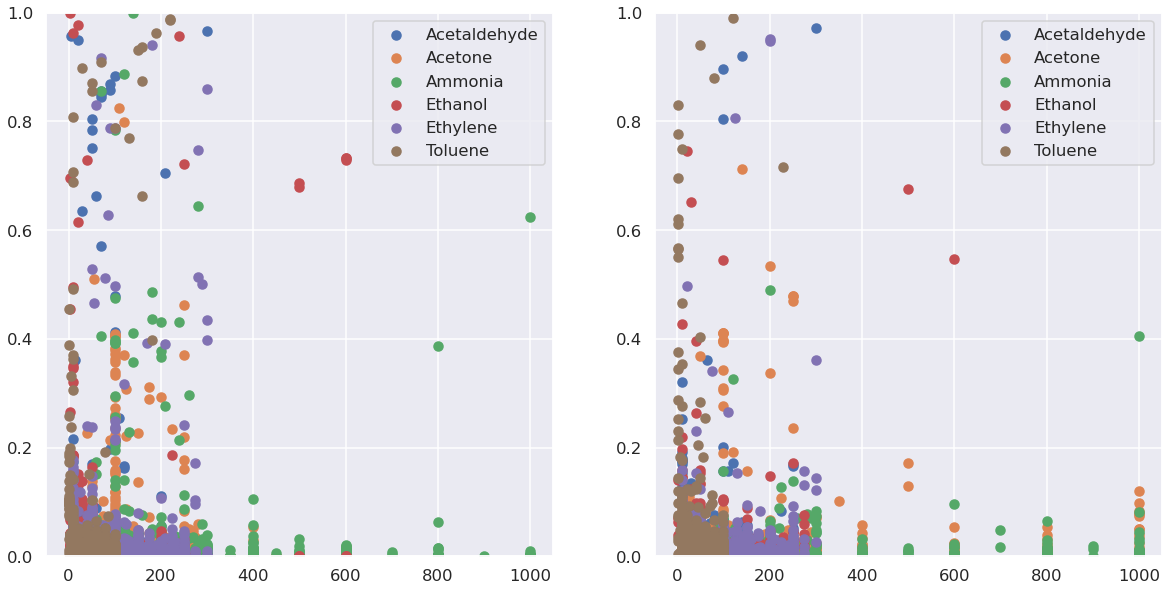

In [188]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

for gas in np.unique(y):
    X_gas = X_reg[y==gas,:]
    y_gas = y_reg[y==gas]
    X_gas_cv = X_reg_cv[y_cv==gas,:]
    y_gas_cv = y_reg_cv[y_cv==gas]
    reg_svr = SVR(C=5000)
    reg_svr.fit(X_gas,y_gas)
    
    y_gas_pred = reg_svr.predict(X_gas)
    error = abs(y_gas - y_gas_pred)/y_gas
    ax[0].scatter(y_gas, error, label=gas)

    y_gas_pred_cv = reg_svr.predict(X_gas_cv)
    error_cv = abs(y_gas_cv - y_gas_pred_cv)/y_gas_cv
    ax[1].scatter(y_gas_cv, error_cv, label=gas)
    
    print(gas)
    print('Ratio train error within 50%:',len(error[error>.5])/len(error))
    print('Ratio cv error within 50%:',len(error_cv[error_cv>.5])/len(error_cv))
    
    outliers = error>.5
    outliers_cv = error_cv>.5
    clf_otlr = SVC(C=5000, max_iter=5000)
    clf_otlr.fit(X_gas,outliers)
    print('F1 outliers train:',metrics.precision_recall_fscore_support(outliers,clf_otlr.predict(X_gas)))
    print('F1 outliers cv:',metrics.precision_recall_fscore_support(outliers_cv,clf_otlr.predict(X_gas_cv)))
    
ax[0].legend()
ax[0].set_ylim(0,1)
ax[1].legend()
ax[1].set_ylim(0,1)
    

# Try neutral network with the no outlier data

In [213]:
reg_mlp = MLPRegressor(max_iter=1000,hidden_layer_sizes=(136,136,136,136,136 ),alpha=1)
reg_mlp.fit(X_reg,y_reg)

MLPRegressor(alpha=1, hidden_layer_sizes=(136, 136, 136, 136, 136),
             max_iter=1000)

In [214]:
print('score training:',reg_mlp.score(X_reg,y_reg))
print('score cv:',reg_mlp.score(X_reg_cv,y_reg_cv))

score training: 0.9897116728523899
score cv: 0.9819996002067337


(-500.0, 500.0)

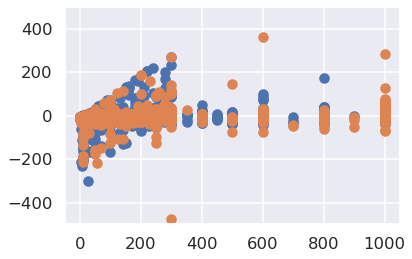

In [215]:
plt.scatter(y_reg,y_reg-reg_mlp.predict(X_reg))
plt.scatter(y_reg_cv,y_reg_cv-reg_mlp.predict(X_reg_cv))
plt.ylim(-500,500)

In [216]:
len(y_reg_cv[abs(y_reg_cv-reg_mlp.predict(X_reg_cv))/y_reg_cv > .2])/len(y_reg_cv)

0.19841840402588065

In [217]:
len(y_reg[abs(y_reg-reg_mlp.predict(X_reg))/y_reg > .2])/len(y_reg)

0.1864366163431584